In [1]:
# Import libraries
import os
import torch
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Any, Dict, List

from datasets import load_dataset, Audio, concatenate_datasets
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback
)
from peft import get_peft_model, LoraConfig, TaskType

In [47]:
from huggingface_hub import notebook_login
notebook_login()

In [52]:
from datasets import load_dataset, Audio
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# ===============================
# Config
# ===============================
CACHE_DIR = "./cache"
MODEL_ID = "openai/whisper-small"

# ===============================
# Load dataset (1%)
# ===============================
common_voice = load_dataset(
    "mozilla-foundation/common_voice_13_0",
    "de",
    cache_dir=CACHE_DIR,
    trust_remote_code=True,   # ✅ cho phép remote code
    split={
        "train": "train[:1%]",
        "validation": "validation[:1%]",
        "test": "test[:1%]"
    }
)

# ===============================
# Resample audio về 16kHz
# ===============================
for split in ["train", "validation", "test"]:
    common_voice[split] = common_voice[split].cast_column("audio", Audio(sampling_rate=16000))

# ===============================
# Load model + processor
# ===============================
processor = WhisperProcessor.from_pretrained(
    MODEL_ID,
    language="de",
    task="transcribe",
    cache_dir=CACHE_DIR
)

model = WhisperForConditionalGeneration.from_pretrained(
    MODEL_ID,
    cache_dir=CACHE_DIR
)

model.freeze_encoder()

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 4598it [00:00, 45958.79it/s]
Reading metadata...: 9194it [00:00, 17910.85it/s]
Reading metadata...: 14873it [00:00, 27499.19it/s]
Reading metadata...: 20511it [00:00, 35022.66it/s]
Reading metadata...: 25921it [00:00, 40189.70it/s]
Reading metadata...: 30850it [00:00, 36689.72it/s]
Reading metadata...: 38816it [00:01, 47651.67it/s]
Reading metadata...: 44320it [00:01, 46726.30it/s]
Reading metadata...: 52008it [00:01, 54667.04it/s]
Reading metadata...: 58738it [00:01, 58119.81it/s]
Reading metadata...: 64931it [00:01, 57283.00it/s]
Reading metadata...: 70924it [00:01, 50243.99it/s]
Reading metadata...: 83185it [00:01, 68859.27it/s]
Reading metadata...: 95813it [00:01, 84277.61it/s]
Reading metadata...: 104817it [00:01, 85820.04it/s]
Reading metadata...: 113815it [00:02, 70375.82it/s]
Reading metadata...: 121583it [00:02, 59073.16it/s]
Reading metadata...: 128245it [00:02, 58623.33it/s]
Reading metadata...: 134627it [00:02, 5

Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 16143it [00:00, 104868.16it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 16143it [00:00, 130988.07it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 6381it [00:00, 38686.82it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 9730it [00:00, 97293.37it/s]
Reading metadata...: 19460it [00:00, 86237.90it/s]
Reading metadata...: 32953it [00:00, 107019.76it/s]
Reading metadata...: 50705it [00:00, 115490.38it/s]


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

In [49]:
from datasets import load_dataset

print(common_voice)
print("Dataset cached at:", common_voice.cache_files)

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 5404
    })
    validation: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 161
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 161
    })
})
Dataset cached at: {'train': [{'filename': '/Users/vietphung/git/speak-german/training/cache/mozilla-foundation___common_voice_13_0/de/13.0.0/2506e9a8950f5807ceae08c2920e814222909fd7f477b74f5d225802e9f04055/common_voice_13_0-train.arrow'}], 'validation': [{'filename': '/Users/vietphung/git/speak-german/training/cache/mozilla-foundation___common_voice_13_0/de/13.0.0/2506e9a8950f5807cea

In [50]:
# Take a random sample from the training set
sample = common_voice["train"][0]
print(sample)

# ▶️ Play the audio file directly inside Jupyter Notebook
import IPython.display as ipd
ipd.Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

{'client_id': '2a2542c35dd80feb743539a32e8c856a4bfce196ae633b0d71c4c4d1b988720c795a9c3f8c38a0af7ba9e366e6431527688cc21c8bb5c88f437c311ce518b51b', 'path': '/Users/vietphung/git/speak-german/training/cache/downloads/extracted/4411fd7718fbccd84e4c91d664f30afa1ab4b843252733e6dc8f12ecce391a4b/de_train_0/common_voice_de_19130994.mp3', 'audio': {'path': '/Users/vietphung/git/speak-german/training/cache/downloads/extracted/4411fd7718fbccd84e4c91d664f30afa1ab4b843252733e6dc8f12ecce391a4b/de_train_0/common_voice_de_19130994.mp3', 'array': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.90568619e-06, 4.44464149e-06, 7.46920705e-06]), 'sampling_rate': 16000}, 'sentence': 'Damit war das erklärte Ziel des Teams verfehlt.', 'up_votes': 2, 'down_votes': 0, 'age': '', 'gender': '', 'accent': '', 'locale': 'de', 'segment': '', 'variant': ''}


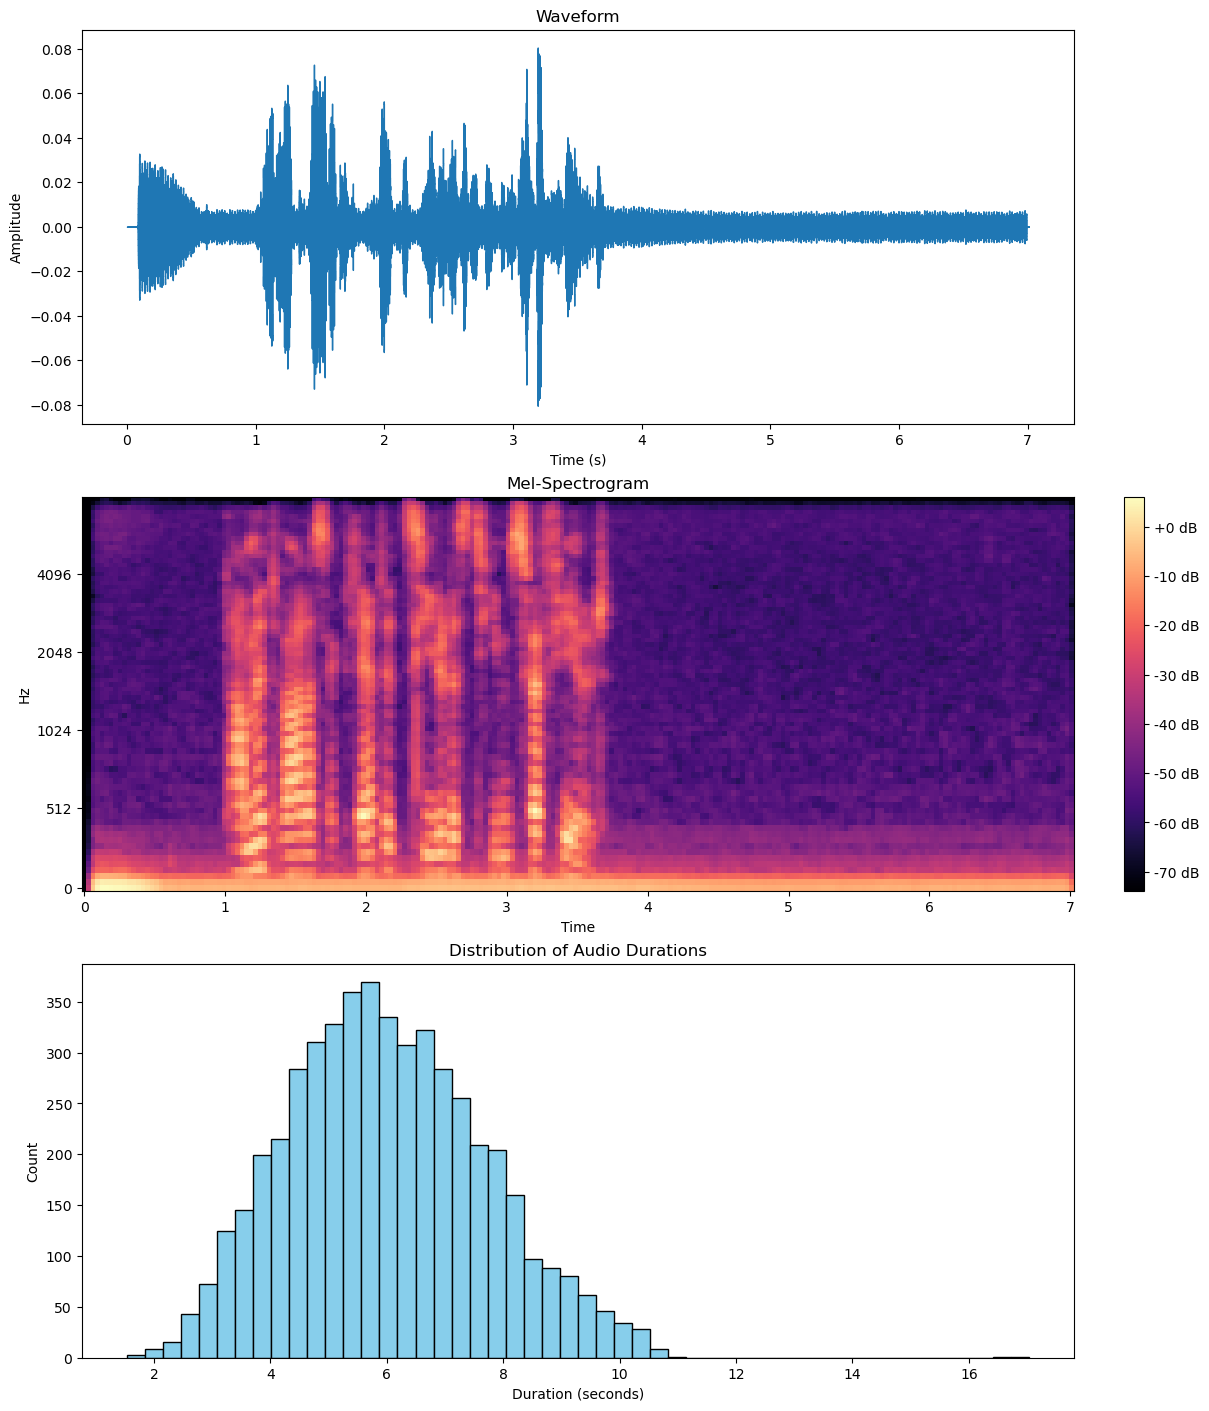

Transcript: Damit war das erklärte Ziel des Teams verfehlt.


In [51]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd

# Select one sample to visualize
sample = common_voice["train"][0]
audio = sample["audio"]["array"]
sr = sample["audio"]["sampling_rate"]
transcript = sample["sentence"]

# Compute durations for a subset of the dataset
durations = [
    len(x["audio"]["array"]) / x["audio"]["sampling_rate"]
    for x in common_voice["train"].select(range(5000))
]

# Create figure with 3 rows
fig, axs = plt.subplots(3, 1, figsize=(12, 14), constrained_layout=True)

# 1. Waveform
librosa.display.waveshow(audio, sr=sr, ax=axs[0])
axs[0].set_title("Waveform")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")

# 2. Mel-Spectrogram
melspec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=80)
log_melspec = librosa.power_to_db(melspec)
img = librosa.display.specshow(log_melspec, sr=sr, x_axis="time", y_axis="mel", ax=axs[1])
axs[1].set_title("Mel-Spectrogram")
fig.colorbar(img, ax=axs[1], format="%+2.0f dB")

# 3. Histogram of audio durations
axs[2].hist(durations, bins=50, color="skyblue", edgecolor="black")
axs[2].set_title("Distribution of Audio Durations")
axs[2].set_xlabel("Duration (seconds)")
axs[2].set_ylabel("Count")

plt.show()

# Listen to the selected sample
print("Transcript:", transcript)
ipd.display(ipd.Audio(audio, rate=sr))

In [7]:
def preprocess(batch):
    audio = batch["audio"]
    inputs = processor(
        audio["array"],
        sampling_rate=audio["sampling_rate"],
        text=batch["sentence"],
        return_tensors="pt",
        padding=True
    )
    batch["input_features"] = inputs.input_features[0]
    batch["labels"] = inputs.labels[0]
    return batch

common_voice = common_voice.map(
    preprocess,
    remove_columns=common_voice["train"].column_names
)

# Xem một ví dụ ra kết quả
print(common_voice["train"][0])

Map:   0%|          | 0/5404 [00:00<?, ? examples/s]

Map:   0%|          | 0/161 [00:00<?, ? examples/s]

Map:   0%|          | 0/161 [00:00<?, ? examples/s]

{'input_features': [[-1.1612167358398438, -1.1612167358398438, -1.1612167358398438, -1.1612167358398438, -1.1612167358398438, -1.1612167358398438, -1.1612167358398438, -1.1612167358398438, 0.5034033060073853, 0.7646056413650513, 0.7937163710594177, 0.7843399047851562, 0.776806116104126, 0.7934489250183105, 0.7822030186653137, 0.798447847366333, 0.7665431499481201, 0.7663739323616028, 0.7861847877502441, 0.7889717221260071, 0.7701151371002197, 0.7817656397819519, 0.76083904504776, 0.7713627219200134, 0.7543832659721375, 0.7607038617134094, 0.7764860391616821, 0.7999396920204163, 0.7460548877716064, 0.7433115839958191, 0.7480573654174805, 0.7553524971008301, 0.7301293611526489, 0.7158845663070679, 0.7376266717910767, 0.7571663856506348, 0.744414210319519, 0.7359210252761841, 0.7128616571426392, 0.7054072022438049, 0.6964025497436523, 0.6999452114105225, 0.6778153777122498, 0.6803251504898071, 0.6727340221405029, 0.6627122163772583, 0.6423724889755249, 0.6352752447128296, 0.58933836221694

In [38]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": f["input_features"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.feature_extractor.pad(
            input_features, return_tensors="pt", padding=True
        )
        labels_batch = self.processor.tokenizer.pad(
            label_features, return_tensors="pt", padding=True
        )

        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )
        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [39]:
import evaluate

wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

In [40]:
def compute_metrics(eval_pred):
    pred_ids = eval_pred.predictions
    label_ids = eval_pred.label_ids

    # Decode predictions
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)

    # Decode labels (thay -100 = pad_token_id để decode đúng)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # Tính WER & CER
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer, "cer": cer}

In [41]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-de-lora",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    logging_steps=50,
    num_train_epochs=3,
    save_steps=500,
    eval_steps=500,
    learning_rate=1e-4,
    warmup_steps=500,
    save_total_limit=2,
    predict_with_generate=True,
    generation_max_length=225,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    no_cuda=True,  # <<< Đặc biệt: ép CPU training
)

In [43]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,               # TrainingArguments đã được điều chỉnh
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["validation"],
    data_collator=data_collator,     # sử dụng collator có padding=True
    tokenizer=processor.feature_extractor,  # để xử lý input
    compute_metrics=compute_metrics
)

trainer.train()

metrics = trainer.evaluate(eval_dataset=common_voice["test"])
print(metrics)

/var/folders/s9/0_833yns18b0vyzdcytknz8r0000gn/T/ipykernel_2560/1397540525.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


ValueError: Unable to create tensor, you should probably activate padding with 'padding=True' to have batched tensors with the same length.